# 03 – Emotion Sentiment vs. Post-Call Returns

This notebook mirrors the returns pipeline from notebook 02, swapping in the emotion-based sentiment features (anger, disgust, fear, joy, neutral, sadness, surprise). All fields are suffixed with `_emotion` to avoid collisions with FinBERT metrics.

## Imports & configuration

In [116]:
from __future__ import annotations

import json
import logging
from pathlib import Path
from typing import Iterable, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.dataset as ds
import pyarrow.parquet as pq
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

plt.style.use('seaborn-v0_8')
pd.options.display.max_columns = 60
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

DATA_DIR = Path('data')
OUTPUT_DIR = Path('output')
FIG_DIR = OUTPUT_DIR / 'fig'
OUTPUT_DIR.mkdir(exist_ok=True)
FIG_DIR.mkdir(exist_ok=True)

EMOTION_PATHS = [OUTPUT_DIR / 'emotion_sentiment_features.parquet', OUTPUT_DIR / 'emotion_sentiment_features.csv']
EC_MAPPING_PATH = DATA_DIR / 'ec_mapping.parquet'
PRICES_PATH = DATA_DIR / 'algoseek_nyse_nasdaq.parquet'

RETURN_WINDOWS = [1, 3, 5]
MERGE_TOLERANCE_DAYS = 5
PRICE_COLUMNS = ['Date', 'Ticker', 'CloseAdjusted']
PRICE_CHUNK_SIZE = 60
RANDOM_STATE = 42


In [117]:
matplotlib_dark_theme = True

if matplotlib_dark_theme:
	plt.rcParams.update({
		# Fonts and text
		"text.color": "white",
		"axes.labelcolor": "white",
		"xtick.color": "white",
		"ytick.color": "white",

		# Axes/spines
		"axes.edgecolor": "white",  # borders
		"xtick.color": "white",
		"ytick.color": "white",
		"grid.color": "white",

		# Background
		"figure.facecolor": "none",  # transparent
		"axes.facecolor": "none"
	})

## Helper utilities

In [118]:
def chunked(seq: Iterable[str], size: int) -> Iterable[List[str]]:
    seq = list(seq)
    for idx in range(0, len(seq), max(size, 1)):
        yield seq[idx: idx + size]

def save_figure(fig: plt.Figure, name: str) -> None:
    path = FIG_DIR / f'{name}.png'
    fig.savefig(path, dpi=160, bbox_inches='tight')
    logging.info('Saved %s', path)

def load_emotion_df(paths: List[Path]) -> pd.DataFrame:
    for path in paths:
        if path.exists():
            if path.suffix.lower() == '.parquet':
                return pd.read_parquet(path)
            if path.suffix.lower() == '.csv':
                return pd.read_csv(path)
    raise FileNotFoundError('Emotion features file not found. Checked: ' + ', '.join(str(p) for p in paths))

def add_suffix(df: pd.DataFrame, suffix: str, keys: List[str]) -> pd.DataFrame:
    rename_map = {col: f'{col}{suffix}' for col in df.columns if col not in keys}
    return df.rename(columns=rename_map)

def emotion_feature_columns(df: pd.DataFrame) -> List[str]:
    return sorted([col for col in df.columns if col.startswith('p_') and col.endswith('_wmean_emotion')])

def load_price_panel(price_path: Path, tickers: Iterable[str], start_date: pd.Timestamp, end_date: pd.Timestamp, columns: List[str], chunk_size: int = 60) -> pd.DataFrame:
    dataset = ds.dataset(price_path, format='parquet')
    frames = []
    start_date = pd.to_datetime(start_date).date()
    end_date = pd.to_datetime(end_date).date()
    start_str = start_date.isoformat()
    end_str = end_date.isoformat()
    import pyarrow as pa
    date_is_string = pa.types.is_string(dataset.schema.field('Date').type)
    for batch in chunked(sorted(set(map(str, tickers))), chunk_size):
        if date_is_string:
            date_filter = (ds.field('Date') >= start_str) & (ds.field('Date') <= end_str)
        else:
            date_filter = (ds.field('Date') >= start_date) & (ds.field('Date') <= end_date)
        filt = (ds.field('Ticker').isin(batch)) & date_filter
        table = dataset.to_table(columns=columns, filter=filt)
        if table.num_rows:
            frames.append(table.to_pandas())
    if not frames:
        return pd.DataFrame(columns=columns)
    out = pd.concat(frames, ignore_index=True)
    out['Date'] = pd.to_datetime(out['Date'])
    out['Ticker'] = out['Ticker'].astype(str)
    out = out.sort_values(['Date','Ticker']).reset_index(drop=True)
    return out

def attach_forward_returns(price_df: pd.DataFrame, windows: List[int]) -> pd.DataFrame:
    price_df = price_df.sort_values(['Ticker','Date']).reset_index(drop=True).copy()
    for window in windows:
        price_df[f'CloseAdjusted_plus_{window}'] = price_df.groupby('Ticker')['CloseAdjusted'].shift(-window)
    return price_df

def merge_event_returns(events: pd.DataFrame, price_panel: pd.DataFrame, windows: List[int], tolerance_days: int = 5) -> pd.DataFrame:
    if price_panel.empty:
        raise ValueError('Price panel empty')
    prices = price_panel.copy()
    prices['Ticker'] = prices['Ticker'].astype(str)
    prices = prices.sort_values(['Date','Ticker'], kind='mergesort').reset_index(drop=True)
    events = events.copy()
    events = events[events['symbol'].notna() & events['rdq'].notna()]
    events['symbol'] = events['symbol'].astype(str)
    events['rdq'] = pd.to_datetime(events['rdq'])
    events = events.sort_values(['rdq','symbol'], kind='mergesort').reset_index(drop=True)
    base_cols = ['Ticker','Date','CloseAdjusted'] + [f'CloseAdjusted_plus_{w}' for w in windows]
    prices_base = prices[base_cols].sort_values(['Date','Ticker'], kind='mergesort').reset_index(drop=True)
    left = events.rename(columns={'symbol':'Ticker'}).sort_values(['rdq','Ticker'], kind='mergesort').reset_index(drop=True)
    merged = pd.merge_asof(left, prices_base, left_on='rdq', right_on='Date', by='Ticker', direction='forward', tolerance=pd.Timedelta(days=tolerance_days))
    merged = merged.rename(columns={'Ticker':'symbol','Date':'price_anchor_date','CloseAdjusted':'anchor_close'})
    merged['price_matched'] = merged['anchor_close'].notna()
    for window in windows:
        future = f'CloseAdjusted_plus_{window}'
        merged[future] = merged[future].astype(float)
        merged[f'return_{window}d'] = np.where((merged['price_matched']) & (merged['anchor_close'] > 0), merged[future] / merged['anchor_close'] - 1, np.nan)
        merged = merged.drop(columns=[future])
    return merged


In [119]:
emotion_raw = load_emotion_df(EMOTION_PATHS)
logging.info('Emotion features shape: rows=%s, cols=%s', len(emotion_raw), len(emotion_raw.columns))
keys = ['symbol','year','quarter']
emotion_df = add_suffix(emotion_raw, '_emotion', keys)
prob_cols = [col for col in emotion_df.columns if col.startswith('p_') and col.endswith('_wmean_emotion')]
positive_candidates = [col for col in prob_cols if any(term in col for term in ['joy','surprise'])]
negative_candidates = [col for col in prob_cols if any(term in col for term in ['anger','fear','sadness','disgust'])]
if positive_candidates:
    emotion_df['max_positive_emotion'] = emotion_df[positive_candidates].max(axis=1)
else:
    emotion_df['max_positive_emotion'] = np.nan
if negative_candidates:
    emotion_df['max_negative_emotion'] = emotion_df[negative_candidates].max(axis=1)
else:
    emotion_df['max_negative_emotion'] = np.nan
emotion_df.head()


INFO: Emotion features shape: rows=77304, cols=44


,symbol,year,quarter,p_anger_wmean_emotion,p_anger_std_emotion,p_anger_q95_emotion,p_anger_q05_emotion,share_anger_gt70_emotion,p_disgust_wmean_emotion,p_disgust_std_emotion,p_disgust_q95_emotion,p_disgust_q05_emotion,share_disgust_gt70_emotion,p_fear_wmean_emotion,p_fear_std_emotion,p_fear_q95_emotion,p_fear_q05_emotion,share_fear_gt70_emotion,p_joy_wmean_emotion,p_joy_std_emotion,p_joy_q95_emotion,p_joy_q05_emotion,share_joy_gt70_emotion,p_neutral_wmean_emotion,p_neutral_std_emotion,p_neutral_q95_emotion,p_neutral_q05_emotion,share_neutral_gt70_emotion,p_sadness_wmean_emotion,p_sadness_std_emotion,p_sadness_q95_emotion,p_sadness_q05_emotion,share_sadness_gt70_emotion,p_surprise_wmean_emotion,p_surprise_std_emotion,p_surprise_q95_emotion,p_surprise_q05_emotion,share_surprise_gt70_emotion,entropy_wmean_emotion,n_chunks_emotion,n_tokens_total_emotion,max_positive_emotion,max_negative_emotion,n_sentences_emotion
0,A,2010,1,0.008933,0.003497,0.013525,0.003970,0.0,0.008348,0.004749,0.012334,0.002638,0.0,0.005893,0.003775,0.013294,0.001621,0.0,0.113997,0.227059,0.640054,0.002812,0.040000,0.728694,0.269779,0.946989,0.148083,0.720000,0.011226,0.009327,0.033172,0.003861,0.0,0.122908,0.209493,0.672348,0.011412,0.08,0.575837,25,10419,0.122908,0.011226,324
1,A,2010,2,0.010941,0.004030,0.018254,0.004394,0.0,0.008306,0.004440,0.018732,0.003617,0.0,0.019416,0.026137,0.072528,0.001551,0.0,0.096009,0.185982,0.464300,0.003430,0.047619,0.791947,0.181121,0.959640,0.463670,0.809524,0.008836,0.004697,0.017197,0.002553,0.0,0.064547,0.064038,0.162954,0.012453,0.00,0.616016,21,9219,0.096009,0.019416,388
2,A,2011,1,0.009082,0.003296,0.014059,0.004869,0.0,0.007912,0.003533,0.014067,0.003319,0.0,0.013853,0.036953,0.053342,0.001962,0.0,0.064644,0.152841,0.280291,0.003140,0.037037,0.836004,0.152700,0.936668,0.639606,0.888889,0.009245,0.012394,0.031321,0.002849,0.0,0.059261,0.027353,0.096546,0.021493,0.00,0.540434,27,11548,0.064644,0.013853,504
3,A,2011,2,0.008180,0.002514,0.012019,0.004792,0.0,0.006992,0.002104,0.009963,0.003612,0.0,0.003872,0.001620,0.006970,0.001730,0.0,0.082289,0.187086,0.574969,0.004166,0.040000,0.802397,0.224004,0.949252,0.239299,0.800000,0.010410,0.023560,0.016560,0.002679,0.0,0.085859,0.152046,0.137762,0.015577,0.04,0.534838,25,10551,0.085859,0.010410,517
4,A,2011,3,0.010289,0.004479,0.018712,0.004281,0.0,0.009136,0.004123,0.017295,0.004270,0.0,0.053072,0.117407,0.193601,0.001586,0.0,0.075774,0.111681,0.312973,0.002526,0.000000,0.774811,0.153195,0.956065,0.519122,0.680000,0.006845,0.003978,0.015832,0.002548,0.0,0.070074,0.076711,0.146981,0.016863,0.00,0.671047,25,10797,0.075774,0.053072,524


In [120]:
mapping_df = pq.read_table(EC_MAPPING_PATH).to_pandas()
mapping_df['rdq'] = pd.to_datetime(mapping_df['rdq'])
events_df = emotion_df.merge(mapping_df, on=keys, how='inner')
events_df = events_df.sort_values(['symbol','rdq']).reset_index(drop=True)
events_df['event_year'] = events_df['rdq'].dt.year
events_df.head()


,symbol,year,quarter,p_anger_wmean_emotion,p_anger_std_emotion,p_anger_q95_emotion,p_anger_q05_emotion,share_anger_gt70_emotion,p_disgust_wmean_emotion,p_disgust_std_emotion,p_disgust_q95_emotion,p_disgust_q05_emotion,share_disgust_gt70_emotion,p_fear_wmean_emotion,p_fear_std_emotion,p_fear_q95_emotion,p_fear_q05_emotion,share_fear_gt70_emotion,p_joy_wmean_emotion,p_joy_std_emotion,p_joy_q95_emotion,p_joy_q05_emotion,share_joy_gt70_emotion,p_neutral_wmean_emotion,p_neutral_std_emotion,p_neutral_q95_emotion,p_neutral_q05_emotion,share_neutral_gt70_emotion,p_sadness_wmean_emotion,p_sadness_std_emotion,p_sadness_q95_emotion,p_sadness_q05_emotion,share_sadness_gt70_emotion,p_surprise_wmean_emotion,p_surprise_std_emotion,p_surprise_q95_emotion,p_surprise_q05_emotion,share_surprise_gt70_emotion,entropy_wmean_emotion,n_chunks_emotion,n_tokens_total_emotion,max_positive_emotion,max_negative_emotion,n_sentences_emotion,rdq,event_year
0,A,2010,1,0.008933,0.003497,0.013525,0.003970,0.0,0.008348,0.004749,0.012334,0.002638,0.0,0.005893,0.003775,0.013294,0.001621,0.0,0.113997,0.227059,0.640054,0.002812,0.040000,0.728694,0.269779,0.946989,0.148083,0.720000,0.011226,0.009327,0.033172,0.003861,0.0,0.122908,0.209493,0.672348,0.011412,0.08,0.575837,25,10419,0.122908,0.011226,324,2010-02-12,2010
1,A,2010,2,0.010941,0.004030,0.018254,0.004394,0.0,0.008306,0.004440,0.018732,0.003617,0.0,0.019416,0.026137,0.072528,0.001551,0.0,0.096009,0.185982,0.464300,0.003430,0.047619,0.791947,0.181121,0.959640,0.463670,0.809524,0.008836,0.004697,0.017197,0.002553,0.0,0.064547,0.064038,0.162954,0.012453,0.00,0.616016,21,9219,0.096009,0.019416,388,2010-05-17,2010
2,A,2011,1,0.009082,0.003296,0.014059,0.004869,0.0,0.007912,0.003533,0.014067,0.003319,0.0,0.013853,0.036953,0.053342,0.001962,0.0,0.064644,0.152841,0.280291,0.003140,0.037037,0.836004,0.152700,0.936668,0.639606,0.888889,0.009245,0.012394,0.031321,0.002849,0.0,0.059261,0.027353,0.096546,0.021493,0.00,0.540434,27,11548,0.064644,0.013853,504,2011-02-14,2011
3,A,2011,2,0.008180,0.002514,0.012019,0.004792,0.0,0.006992,0.002104,0.009963,0.003612,0.0,0.003872,0.001620,0.006970,0.001730,0.0,0.082289,0.187086,0.574969,0.004166,0.040000,0.802397,0.224004,0.949252,0.239299,0.800000,0.010410,0.023560,0.016560,0.002679,0.0,0.085859,0.152046,0.137762,0.015577,0.04,0.534838,25,10551,0.085859,0.010410,517,2011-05-13,2011
4,A,2011,3,0.010289,0.004479,0.018712,0.004281,0.0,0.009136,0.004123,0.017295,0.004270,0.0,0.053072,0.117407,0.193601,0.001586,0.0,0.075774,0.111681,0.312973,0.002526,0.000000,0.774811,0.153195,0.956065,0.519122,0.680000,0.006845,0.003978,0.015832,0.002548,0.0,0.070074,0.076711,0.146981,0.016863,0.00,0.671047,25,10797,0.075774,0.053072,524,2011-08-15,2011


In [121]:
coverage_year = events_df.groupby('event_year')['symbol'].agg(['count','nunique']).rename(columns={'count':'call_count','nunique':'unique_symbols'})
coverage_year


,call_count,unique_symbols
event_year,,
2009,48,48
2010,1747,724
2011,2319,725
2012,3640,1088
2013,3712,1093
2014,4791,1339
2015,5283,1381
2016,4819,1378
2017,5124,1390


INFO: Saved output/fig/emotion_returns_calls_per_year.png


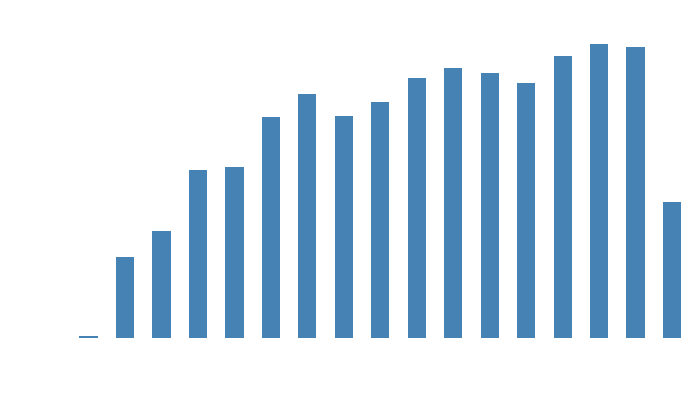

In [122]:
fig, ax = plt.subplots(figsize=(8,4))
events_df.groupby('event_year').size().plot(kind='bar', ax=ax, color='steelblue')
ax.set_ylabel('Number of calls')
ax.set_title('Emotion coverage by year')
ax.grid(axis='y', alpha=0.3)
save_figure(fig, 'emotion_returns_calls_per_year')


In [123]:
date_min = events_df['rdq'].min() - pd.Timedelta(days=2)
date_max = events_df['rdq'].max() + pd.Timedelta(days=max(RETURN_WINDOWS)+5)
tickers = events_df['symbol'].unique()
price_df = load_price_panel(PRICES_PATH, tickers, date_min, date_max, PRICE_COLUMNS, PRICE_CHUNK_SIZE)
logging.info('Price panel shape: %s', price_df.shape)
price_aug = attach_forward_returns(price_df, RETURN_WINDOWS)
feature_cols = emotion_feature_columns(emotion_df)
extra_cols = [col for col in ['entropy_wmean_emotion','n_chunks_emotion','n_tokens_total_emotion','n_sentences_emotion','max_positive_emotion','max_negative_emotion'] if col in emotion_df.columns]
events_subset = events_df[['symbol','rdq'] + feature_cols + extra_cols]
events_with_returns = merge_event_returns(events_subset, price_aug, RETURN_WINDOWS, MERGE_TOLERANCE_DAYS)
match_rate = events_with_returns['price_matched'].mean() if len(events_with_returns) else 0.0
logging.info('Merged rows: %s; price match rate %.1f%%', len(events_with_returns), 100*match_rate)
model_df = events_with_returns[events_with_returns['price_matched']].copy()
model_df.head()


INFO: Price panel shape: (4829520, 3)
INFO: Merged rows: 75999; price match rate 82.6%


,symbol,rdq,p_anger_wmean_emotion,p_disgust_wmean_emotion,p_fear_wmean_emotion,p_joy_wmean_emotion,p_neutral_wmean_emotion,p_sadness_wmean_emotion,p_surprise_wmean_emotion,entropy_wmean_emotion,n_chunks_emotion,n_tokens_total_emotion,n_sentences_emotion,max_positive_emotion,max_negative_emotion,price_anchor_date,anchor_close,price_matched,return_1d,return_3d,return_5d
48,FC,2010-01-07,0.007414,0.007253,0.007162,0.190319,0.713070,0.006969,0.067813,0.532283,23,9546,295,0.190319,0.007414,2010-01-07,6.3600,True,-0.009434,-0.020440,-0.033035
49,WDFC,2010-01-11,0.010111,0.013135,0.012187,0.097688,0.802288,0.027147,0.037444,0.630150,16,6811,248,0.097688,0.027147,2010-01-11,25.0938,True,-0.005555,-0.007408,0.011728
50,COHR,2010-01-19,0.007346,0.005920,0.003514,0.199163,0.685824,0.007235,0.090999,0.684685,12,5232,270,0.199163,0.007346,2010-01-19,28.6578,True,-0.007516,-0.053982,-0.099760
51,PH,2010-01-19,0.008739,0.013737,0.005469,0.050740,0.859839,0.019876,0.041601,0.476388,25,10561,455,0.050740,0.019876,2010-01-19,47.6820,True,-0.012539,-0.061401,-0.078338
52,WOLF,2010-01-19,0.009813,0.013962,0.004886,0.031681,0.870574,0.011287,0.057797,0.487523,31,13058,488,0.057797,0.013962,2010-01-19,2.4200,True,-0.037190,-0.057851,-0.049587


INFO: Saved output/fig/emotion_returns_probability_histograms.png


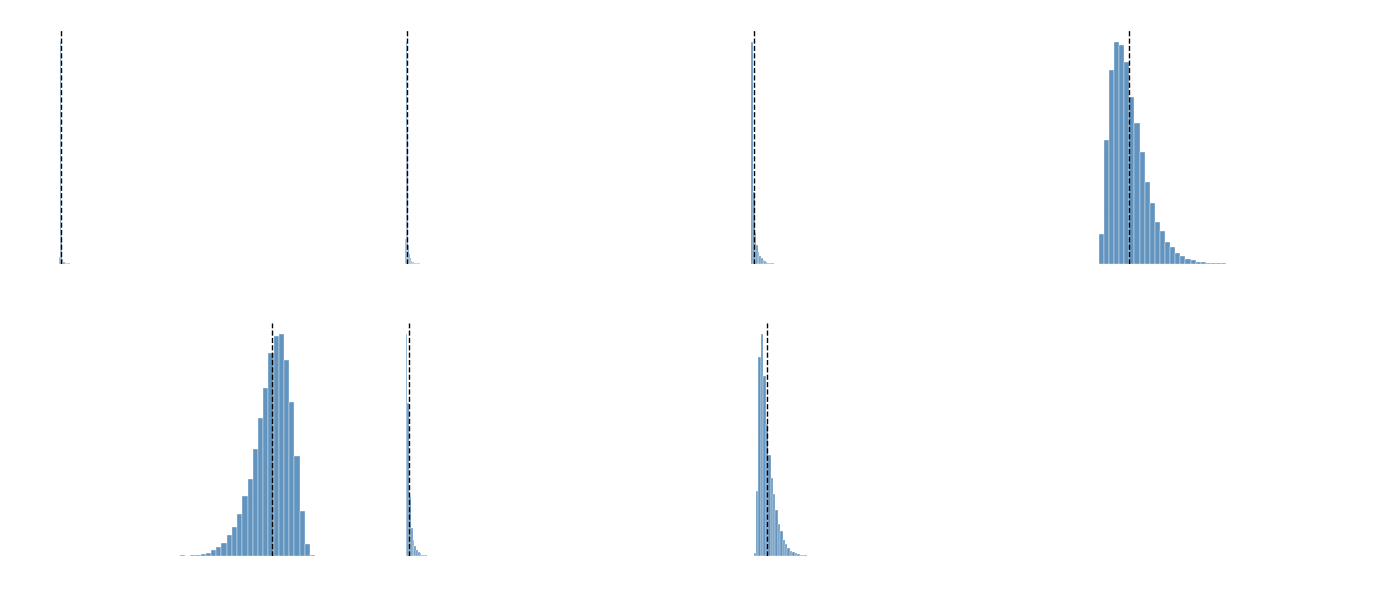

In [124]:
fig, axes = plt.subplots(2, int(np.ceil(len(feature_cols)/2)), figsize=(14,6))
axes = axes.flatten()
for ax, col in zip(axes, feature_cols):
    model_df[col].hist(ax=ax, bins=40, color='steelblue', edgecolor='white', alpha=0.85)
    ax.set_title(col)
    ax.axvline(model_df[col].mean(), color='black', linestyle='--', linewidth=1)
    ax.grid(alpha=0.3)
    ax.set_xlim(0, 1)
for ax in axes[len(feature_cols):]: ax.axis('off')
plt.tight_layout()
save_figure(fig, 'emotion_returns_probability_histograms')


INFO: Saved output/fig/emotion_returns_trends_top4.png


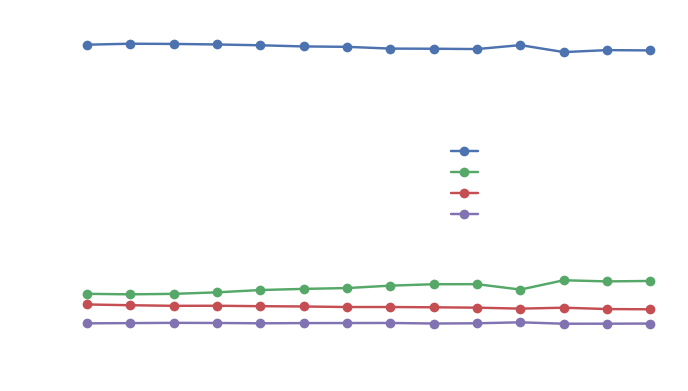

In [125]:
top_emotions = pd.Series({col: model_df[col].mean() for col in feature_cols}).sort_values(ascending=False).index[:4]
trend_df = model_df.groupby(model_df['rdq'].dt.year)[list(top_emotions)].mean().sort_index()
fig, ax = plt.subplots(figsize=(8,4))
trend_df.plot(ax=ax, marker='o')
ax.set_ylabel('Average probability')
ax.set_title('Top emotion probabilities over time')
ax.grid(alpha=0.3)
save_figure(fig, 'emotion_returns_trends_top4')


INFO: Saved output/fig/emotion_returns_heatmap.png


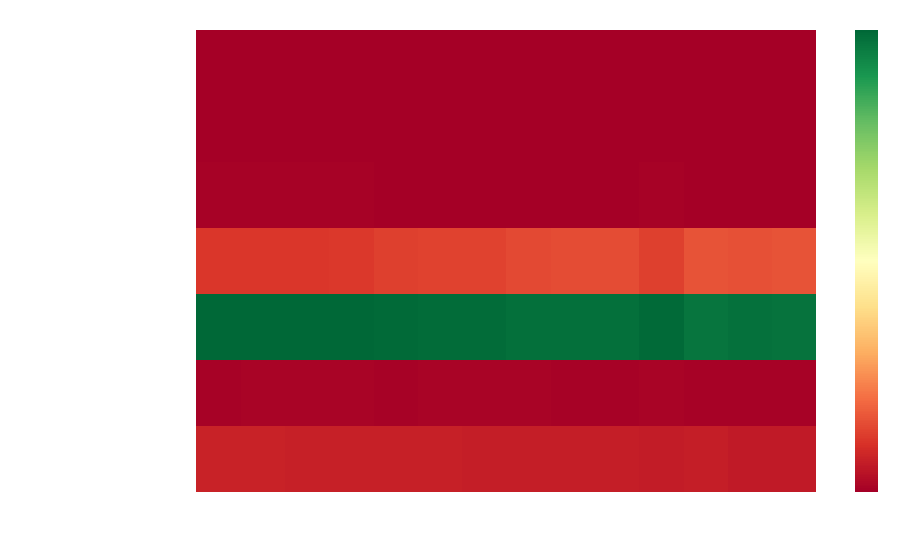

In [126]:
heatmap_df = model_df.groupby(model_df['rdq'].dt.year)[feature_cols].mean().sort_index()
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(heatmap_df.T, cmap='RdYlGn', ax=ax)
ax.set_title('Emotion probabilities by year (mean)')
save_figure(fig, 'emotion_returns_heatmap')


INFO: Saved output/fig/emotion_returns_scatter_joy.png
INFO: Saved output/fig/emotion_returns_scatter_fear.png


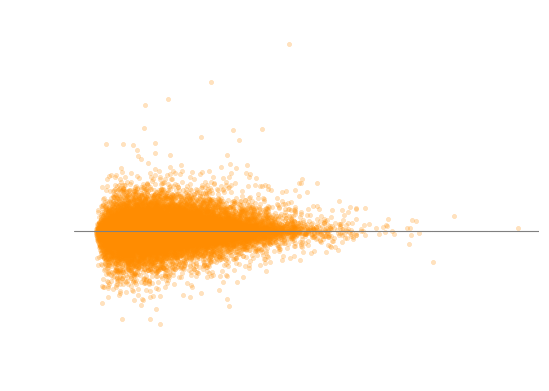

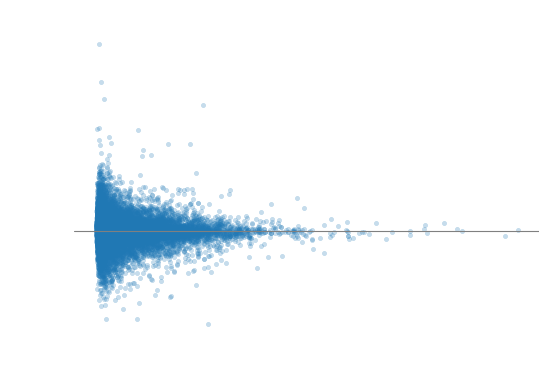

In [127]:
if 'p_joy_wmean_emotion' in model_df.columns:
    fig, ax = plt.subplots(figsize=(6,4))
    ax.scatter(model_df['p_joy_wmean_emotion'], model_df['return_1d'], alpha=0.25, s=10, color='darkorange')
    ax.set_xlabel('Joy (weighted mean)')
    ax.set_ylabel('Return 1d')
    ax.axhline(0, color='grey', linewidth=0.8)
    corr = model_df['p_joy_wmean_emotion'].corr(model_df['return_1d'])
    ax.text(0.02, 0.95, f'r = {corr:.3f}', transform=ax.transAxes)
    ax.grid(alpha=0.3)
    ax.set_title('Joy vs next-day return')
    save_figure(fig, 'emotion_returns_scatter_joy')
if 'p_fear_wmean_emotion' in model_df.columns:
    fig, ax = plt.subplots(figsize=(6,4))
    ax.scatter(model_df['p_fear_wmean_emotion'], model_df['return_1d'], alpha=0.25, s=10, color='#1f77b4')
    ax.set_xlabel('Fear (weighted mean)')
    ax.set_ylabel('Return 1d')
    ax.axhline(0, color='grey', linewidth=0.8)
    corr = model_df['p_fear_wmean_emotion'].corr(model_df['return_1d'])
    ax.text(0.02, 0.95, f'r = {corr:.3f}', transform=ax.transAxes)
    ax.grid(alpha=0.3)
    ax.set_title('Fear vs next-day return')
    save_figure(fig, 'emotion_returns_scatter_fear')


INFO: Saved output/fig/emotion_returns_scatter_grid.png


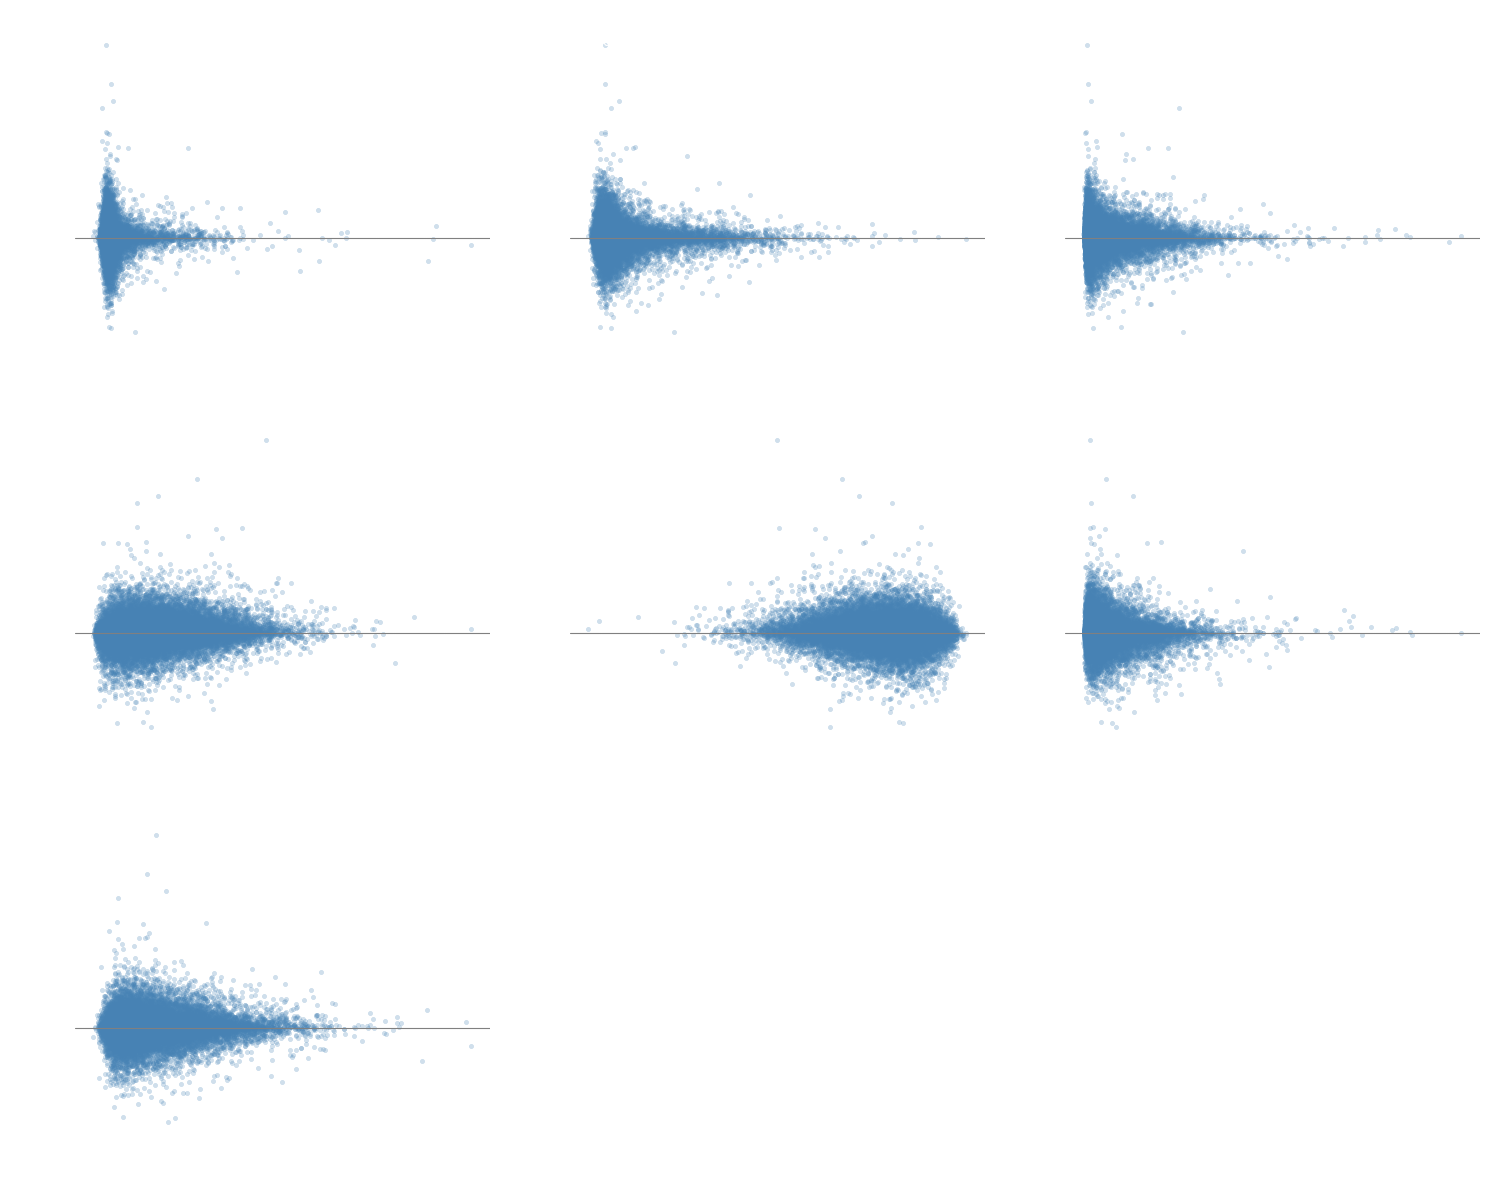

In [128]:
# Scatter plots for all emotion probabilities vs 1d return
emotion_scatter_cols = [col for col in feature_cols if col.endswith('_wmean_emotion')]
n = len(emotion_scatter_cols)
fig, axes = plt.subplots(int(np.ceil(n/3)), 3, figsize=(15, 4*int(np.ceil(n/3))))
axes = axes.flatten()
for ax, col in zip(axes, emotion_scatter_cols):
    ax.scatter(model_df[col], model_df['return_1d'], alpha=0.25, s=10, color='steelblue')
    ax.axhline(0, color='grey', linewidth=0.8)
    ax.grid(alpha=0.3)
    ax.set_title(f'{col} vs return_1d')
    ax.set_xlabel(col)
    ax.set_ylabel('return_1d')
    corr = model_df[col].corr(model_df['return_1d'])
    ax.text(0.02, 0.95, f'r = {corr:.3f}', transform=ax.transAxes)
for ax in axes[len(emotion_scatter_cols):]:
    ax.axis('off')
plt.tight_layout()
save_figure(fig, 'emotion_returns_scatter_grid')


INFO: Saved output/fig/decile_p_anger_wmean_emotion_return_1d.png
INFO: Saved output/fig/decile_p_disgust_wmean_emotion_return_1d.png
INFO: Saved output/fig/decile_p_fear_wmean_emotion_return_1d.png
INFO: Saved output/fig/decile_p_joy_wmean_emotion_return_1d.png
INFO: Saved output/fig/decile_p_neutral_wmean_emotion_return_1d.png
INFO: Saved output/fig/decile_p_sadness_wmean_emotion_return_1d.png
INFO: Saved output/fig/decile_p_surprise_wmean_emotion_return_1d.png
INFO: Saved output/fig/emotion_returns_decile_grid.png


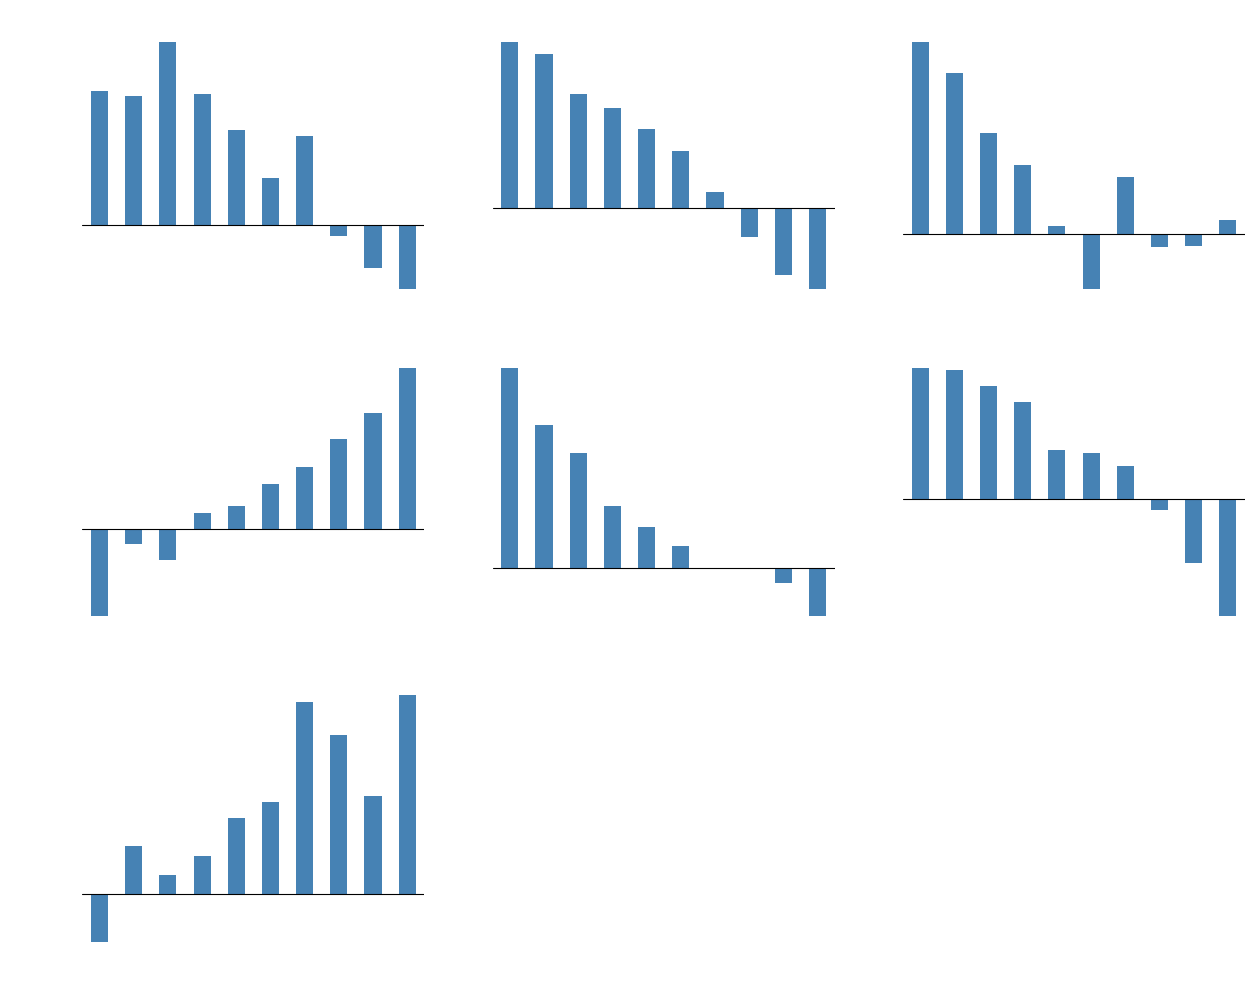

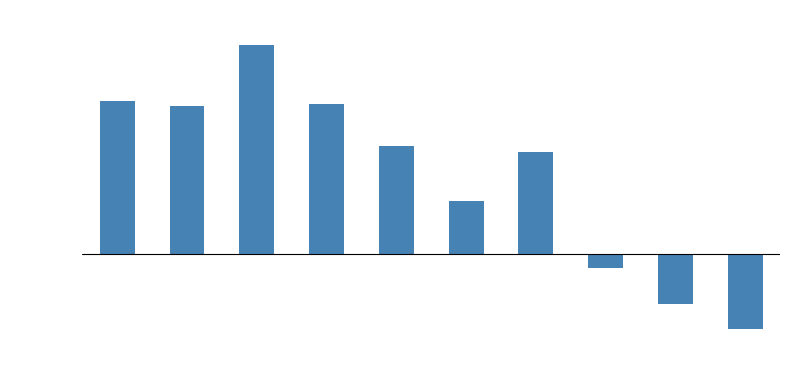

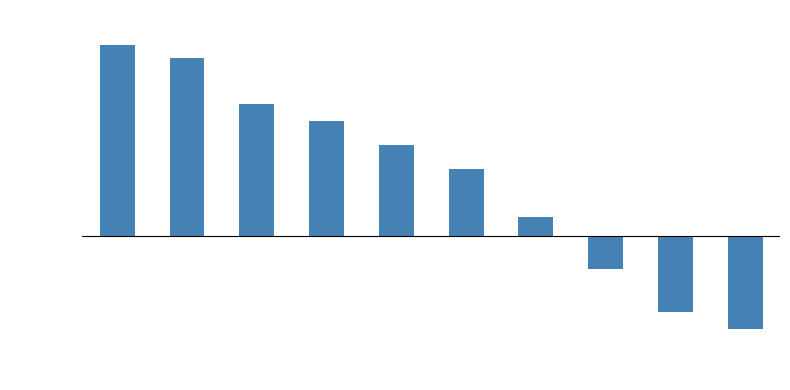

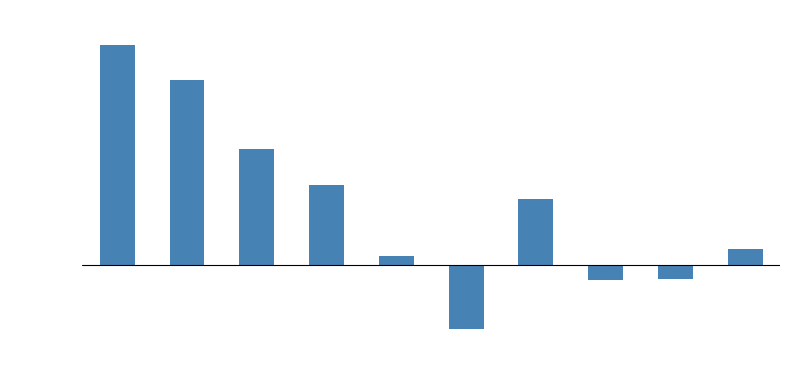

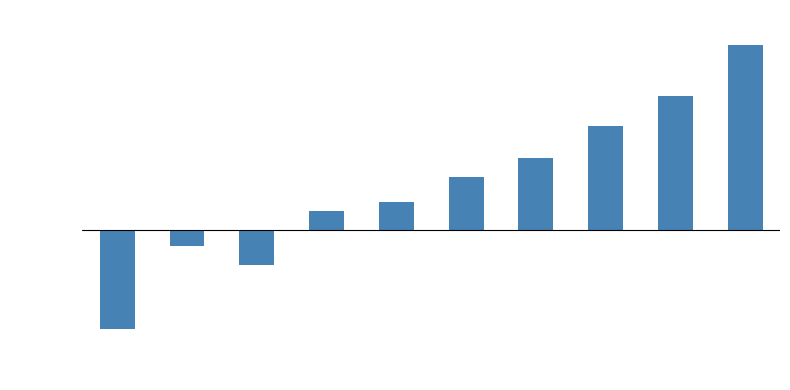

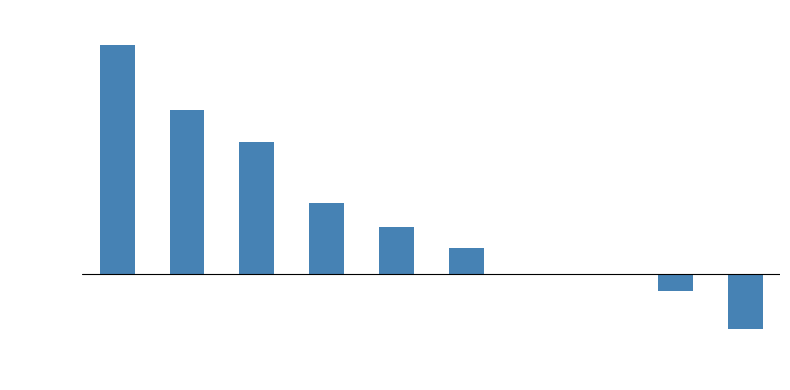

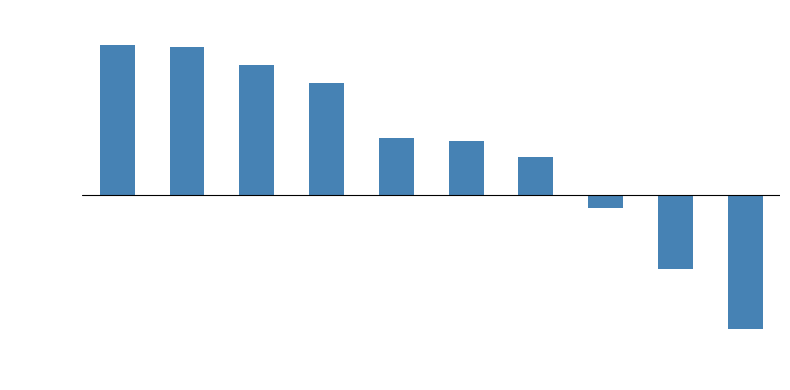

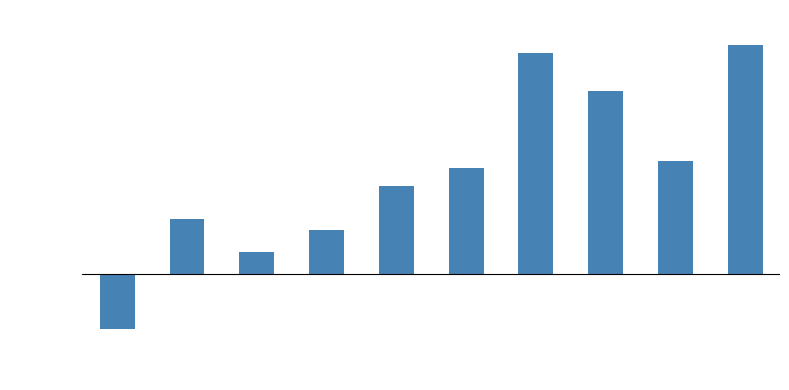

In [129]:
def decile_summary(df: pd.DataFrame, score_col: str, ret_col: str, name: str):
    if score_col not in df.columns:
        return None
    dec = pd.qcut(df[score_col], 10, labels=False, duplicates='drop')
    table = df.groupby(dec)[ret_col].agg(['mean','median','count']).rename_axis('decile')
    fig, ax = plt.subplots(figsize=(8,4))
    table['mean'].plot(kind='bar', ax=ax, color='steelblue')
    ax.set_ylabel(ret_col)
    ax.set_title(f'{ret_col} by decile of {score_col}')
    ax.axhline(0, color='black', linewidth=0.8)
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    save_figure(fig, name)
    return table

# grid of decile plots for all emotion probabilities vs 1d return
emotion_decile_cols = [col for col in feature_cols if col.endswith('_wmean_emotion')]
n = len(emotion_decile_cols)
fig, axes = plt.subplots(int(np.ceil(n/3)), 3, figsize=(15, 4*int(np.ceil(n/3))))
axes = axes.flatten()
for ax, col in zip(axes, emotion_decile_cols):
	table = decile_summary(model_df, col, 'return_1d', f'decile_{col}_return_1d')
	if table is not None:
		table['mean'].plot(kind='bar', ax=ax, color='steelblue')
		ax.set_ylabel('return_1d')
		ax.set_title(f'{col} deciles')
		ax.axhline(0, color='black', linewidth=0.8)
		ax.grid(axis='y', alpha=0.3)
	else:
		ax.axis('off')
for ax in axes[len(emotion_decile_cols):]:
	ax.axis('off')
plt.tight_layout()
save_figure(fig, 'emotion_returns_decile_grid')


In [130]:
emotion_features = feature_cols + [col for col in ['entropy_wmean_emotion','max_positive_emotion','max_negative_emotion'] if col in model_df.columns]
reg_df = model_df.dropna(subset=emotion_features + ['return_1d']).copy()
X = reg_df[emotion_features]
y = reg_df['return_1d']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
lr = LinearRegression().fit(X_train, y_train)

rmse_train = np.sqrt(mean_squared_error(y_train, lr.predict(X_train)))
rmse_test = np.sqrt(mean_squared_error(y_test, lr.predict(X_test)))
metrics = {
    'n_obs': int(len(reg_df)),
    'n_train': int(len(X_train)),
    'n_test': int(len(X_test)),
    'r2_train': float(r2_score(y_train, lr.predict(X_train))),
    'r2_test': float(r2_score(y_test, lr.predict(X_test))),
    'rmse_train': rmse_train,
    'rmse_test': rmse_train,
}
metrics


{'n_obs': 62794,
 'n_train': 47095,
 'n_test': 15699,
 'r2_train': 0.009347826804256942,
 'r2_test': 0.01091196354170465,
 'rmse_train': np.float64(0.06175580625768763),
 'rmse_test': np.float64(0.06175580625768763)}

INFO: Saved output/fig/emotion_returns_regression_coeffs.png


,feature,coefficient
5,p_sadness_wmean_emotion,-13454.648150
1,p_disgust_wmean_emotion,-13454.442277
2,p_fear_wmean_emotion,-13454.367586
0,p_anger_wmean_emotion,-13454.164569
4,p_neutral_wmean_emotion,-13454.105775


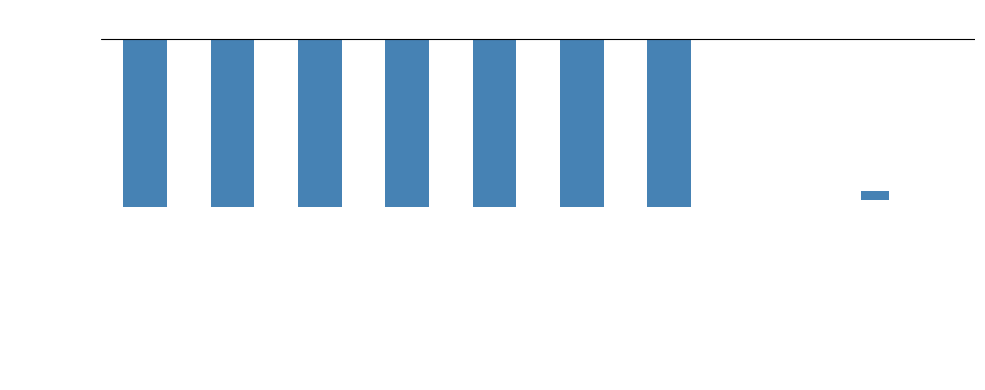

In [131]:
coef_df = pd.DataFrame({'feature': emotion_features, 'coefficient': lr.coef_}).sort_values(by='coefficient', key=lambda s: s.abs(), ascending=False)
fig, ax = plt.subplots(figsize=(10,4))
coef_df.plot(kind='bar', x='feature', y='coefficient', ax=ax, color='steelblue')
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylabel('Coefficient')
ax.set_title('Emotion regression coefficients (return 1d)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
save_figure(fig, 'emotion_returns_regression_coeffs')
coef_df.head()


INFO: Saved output/fig/emotion_returns_residual_hist.png
INFO: Saved output/fig/emotion_returns_residuals_vs_fitted.png


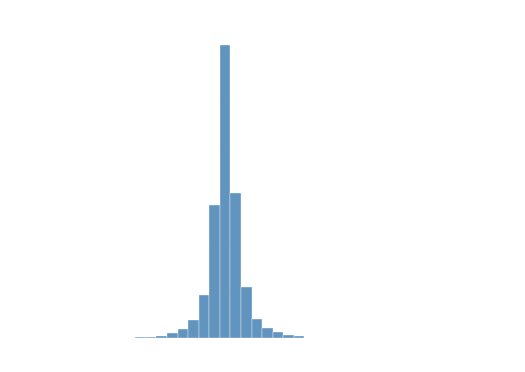

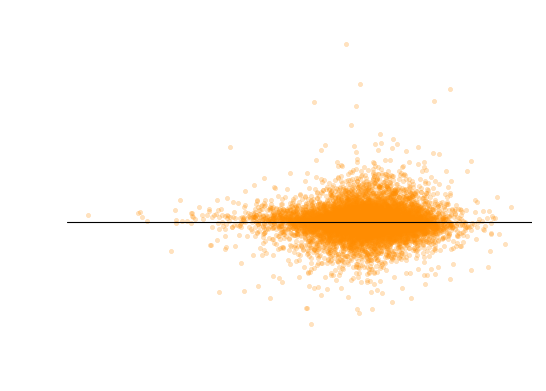

In [132]:
residuals = y_test - lr.predict(X_test)
fig, ax = plt.subplots(figsize=(6,4))
residuals.hist(ax=ax, bins=40, color='steelblue', edgecolor='white', alpha=0.85)
ax.set_title('Residuals (test set)')
ax.grid(alpha=0.3)
save_figure(fig, 'emotion_returns_residual_hist')
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(lr.predict(X_test), residuals, alpha=0.25, s=10, color='darkorange')
ax.axhline(0, color='black', linewidth=0.8)
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
ax.set_title('Residuals vs fitted (emotion regression)')
ax.grid(alpha=0.3)
save_figure(fig, 'emotion_returns_residuals_vs_fitted')
(OUTPUT_DIR / 'emotion_returns_metrics.json').write_text(json.dumps(metrics, indent=2))
coef_df.to_csv(OUTPUT_DIR / 'emotion_returns_coefficients.csv', index=False)
model_df.to_parquet(OUTPUT_DIR / 'emotion_returns.parquet', index=False)
